<a href="https://colab.research.google.com/github/Raziel-JKM/Finance_AI/blob/main/Code/Fanal_%EC%A0%95%EA%B0%95%EB%AF%BC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -U finance-datareader;

import pandas as pd
import numpy as np 
import datetime as dt
import pandas_datareader.data as pdr
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import FinanceDataReader as fdr
from datetime import datetime, timedelta 
import math
from scipy.stats import skew, kurtosis
import csv 
import os.path 
import time

Requirement already up-to-date: finance-datareader in c:\programdata\anaconda3\lib\site-packages (0.9.31)


In [ ]:
# 한국거래소에 있는 주식의 데이터를 가져옴
krx = fdr.StockListing('KOSPI')
krx

,Symbol,Market,Name,Sector,Industry,ListingDate,SettleMonth,Representative,HomePage,Region
1,095570,KOSPI,AJ네트웍스,산업용 기계 및 장비 임대업,"렌탈(파렛트, OA장비, 건설장비)",2015-08-21,12월,박대현,http://www.ajnet.co.kr,서울특별시
2,006840,KOSPI,AK홀딩스,기타 금융업,지주사업,1999-08-11,12월,"채형석, 이석주(각자 대표이사)",http://www.aekyunggroup.co.kr,서울특별시
6,152100,KOSPI,ARIRANG 200,NaN,NaN,NaT,NaN,NaN,NaN,NaN
7,295820,KOSPI,ARIRANG 200동일가중,NaN,NaN,NaT,NaN,NaN,NaN,NaN
8,253150,KOSPI,ARIRANG 200선물레버리지,NaN,NaN,NaT,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
7123,069260,KOSPI,휴켐스,기타 화학제품 제조업,"화합물,화학제품 제조",2002-10-07,12월,신진용,http://www.huchems.com,서울특별시
7127,000540,KOSPI,흥국화재,보험업,손해보험,1974-12-05,12월,권중원,http://www.insurance.co.kr,서울특별시
7128,000547,KOSPI,흥국화재2우B,NaN,NaN,NaT,NaN,NaN,NaN,NaN
7129,000545,KOSPI,흥국화재우,NaN,NaN,NaT,NaN,NaN,NaN,NaN


In [ ]:
!mkdir krx

In [ ]:
from concurrent import futures
import csv

bad = []
krx_list=krx['Symbol'].tolist() #회사 Symbol만을 추출해서 list로 만든다.


In [ ]:
# Default Date : 2010.01.04 ~ 2020.11.30
default_start = dt.datetime(2010,1,4)
default_end = dt.datetime(2020,11,30)

def download(krx_item):
    sym=krx_item
    df=fdr.DataReader(sym, default_start, default_end)
    dfnew=df.copy()
    dfnew['Symbol']  =sym
    dfnew.to_csv(f"krx/{sym}.csv", quoting=csv.QUOTE_MINIMAL)    
    
workers = min(30,len(krx))
with futures.ThreadPoolExecutor(workers) as executor: 
    res = executor.map(download, krx_list) 

In [ ]:
remove_list=[]

import os.path 

stocks=pd.DataFrame()
for krx_item in krx_list:
    filename=f"krx/{krx_item}.csv"
    status=True
    if os.path.isfile(filename):
        tmp=pd.read_csv(f"krx/{krx_item}.csv",parse_dates=True) 
        if ('Close' in tmp.columns) and ('Date' in tmp.columns):
            tmp.set_index(tmp['Date'],inplace=True,drop=False) 
            tmp_close=tmp['Close'].rename(krx_item) 
            stocks=pd.concat([stocks,tmp_close],axis=1,sort=True) 
            status=False

    if status:
        remove_list.append(krx_item)

for remove_item in remove_list: 
    krx_list.remove(remove_item)

stocks = stocks.loc[:,~stocks.columns.duplicated()];



```
1.  (데이터준비) KOSPI지수와개별주식별로일별로다음종가(Close)와수익률(%)의두가지종류의데이터를생성하시오.수익률은다음공식으로계산하시오:rt=  100×ln(Closet/Closet−1).  KOSPI지수와임의의한주식을선택하여결과를출력하시오.
```



In [ ]:
# 개별 주식들 close
stocks_close = stocks
stocks_lag = stocks.shift(1) # KOSPI내의 개별주식들의 lagged Closed 값

In [ ]:
before_log = stocks_close / stocks_lag

In [ ]:
# 개별 주식들 close
stocks_close = stocks

# 개별 주식들의 return. log(T시점 종가 / T-1시점 종가)
with np.errstate(divide='ignore'):
    stocks_return = 100 * np.log((stocks_close / stocks_close.shift(1)).astype('float'))

# 코스피 close
Kospi = pdr.DataReader('^KS11', 'yahoo', default_start, default_end) #KOSPI
kospi = pd.merge(Kospi['Close'], Kospi.shift(1)['Close'],left_index=True, right_index=True, how='inner')

kospi.columns = ['KOSPI Close', 'KOSPI Lag Close']

Kospi_return = 100 * np.log( Kospi['Close'] / Kospi.shift(1)['Close'] )

kospi['KOSPI Return'] = Kospi_return

In [ ]:
samsung = pd.merge(stocks_close['005930'], stocks_lag['005930'], left_index=True, right_index=True, how = 'inner')

In [ ]:
samsung.columns = ['SS Close', 'SS Lag Close']

In [ ]:
samsung['SS Return'] = stocks_return['005930']

In [ ]:
stocks_return

,095570,006840,152100,295820,253150,253160,395750,395760,278420,292750,...,093370,081660,005870,079980,005010,069260,000540,000547,000545,003280
Date,,,,,,,,,,,,,,,,,,,,,
2010-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-05,NaN,-1.217330,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.646206,NaN,3.562020,NaN,1.250016,-3.256247,-3.264385,-1.783992,-1.142870,-0.635062
2010-01-06,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.421507,NaN,3.569447,NaN,3.058342,1.723736,0.900907,2.176149,0.458716,-0.661232
2010-01-07,NaN,0.916811,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.795760,NaN,-1.175716,NaN,0.300752,-1.723736,-2.881170,-2.176149,-2.549385,7.782885
2010-01-08,NaN,0.600137,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.500726,NaN,-0.659198,NaN,-0.300752,0.690769,-0.927364,0.000000,0.000000,-0.739223
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-11-24,-0.215285,5.531364,0.553745,-0.261012,1.017211,-1.077763,NaN,NaN,0.315996,0.000000,...,0.207039,-2.293679,1.669488,0.246609,-0.273973,1.013180,1.257878,0.865806,1.355953,0.000000
2020-11-25,-0.865806,-2.038576,-0.582822,-0.535023,-1.288214,1.383573,NaN,NaN,-1.231683,-0.466907,...,-2.938302,1.268029,-0.331675,-0.617667,2.036730,-1.421344,2.643326,1.497354,-5.537747,0.000000
2020-11-26,-0.763779,-0.919547,1.064486,0.316992,1.955724,-2.082605,NaN,NaN,0.497038,0.862699,...,0.106440,-1.500317,-0.166251,0.000000,0.268457,-1.027758,-0.348432,-0.638980,-3.993271,0.000000


In [ ]:
# BUG. 몇몇 날짜는 krx.stock 값은 없고 kospi 값만 있음.

# ks = set(kospi.index.strftime("%Y-%m-%d"))
# # print(ks)
# ss = set(stocks.index)
# # print(ss)
# print(sorted(list(ss - ks)))

In [ ]:
stocks_close

,095570,006840,152100,295820,253150,253160,395750,395760,278420,292750,...,093370,081660,005870,079980,005010,069260,000540,000547,000545,003280
Date,,,,,,,,,,,,,,,,,,,,,
2010-01-04,NaN,10331,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3726,NaN,7170,NaN,15900,17885,6850,5090,2200,4581
2010-01-05,NaN,10206,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3702,NaN,7430,NaN,16100,17312,6630,5000,2175,4552
2010-01-06,NaN,10206,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3755,NaN,7700,NaN,16600,17613,6690,5110,2185,4522
2010-01-07,NaN,10300,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3785,NaN,7610,NaN,16650,17312,6500,5000,2130,4888
2010-01-08,NaN,10362,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3804,NaN,7560,NaN,16600,17432,6440,5000,2130,4852
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-11-24,4640.0,22300,34588.0,9183.0,33595.0,6460.0,NaN,NaN,7924.0,15886.0,...,9670,43100.0,6040,8120.0,7290,24800,2800,23200,14850,1035
2020-11-25,4600.0,21850,34387.0,9134.0,33165.0,6550.0,NaN,NaN,7827.0,15812.0,...,9390,43650.0,6020,8070.0,7440,24450,2875,23550,14050,1035
2020-11-26,4565.0,21650,34755.0,9163.0,33820.0,6415.0,NaN,NaN,7866.0,15949.0,...,9400,43000.0,6010,8070.0,7460,24200,2865,23400,13500,1035


In [ ]:
#임의의 주식 005930 

samsung

,SS Close,SS Lag Close,SS Return
Date,,,
2010-01-04,16180,NaN,NaN
2010-01-05,16440,16180.0,1.594148
2010-01-06,16820,16440.0,2.285126
2010-01-07,16260,16820.0,-3.386055
2010-01-08,16420,16260.0,0.979200
...,...,...,...
2020-11-24,67700,67500.0,0.295858
2020-11-25,66600,67700.0,-1.638160
2020-11-26,68000,66600.0,2.080313


코스피

In [ ]:
# Get data as dataframe(['Close', 'Lagged Close', 'Return']) of KOSPI or random stock.
# Default Date : 2010.01.04 ~ 2020.11.30

def getStockData (ticker, start=None, end=None) :
  # Setting default values for start day and end day
    if start is None :
        start = default_start
    if end is None :
        end = default_end

    start = start.strftime("%Y-%m-%d")
    end = end.strftime("%Y-%m-%d")  

    df = pd.DataFrame(columns=['Close', 'Lagged Close', 'Return'])

    if ticker == 'kospi' :
        df['Close'] = kospi['Close']
        df['Lagged Close'] = kospi['Close'].shift(1)
    else :
        try : 
            df['Close'] = stocks_close[ticker]
            df['Lagged Close'] = stocks_close[ticker].shift(1)
        except ValueError:
            return df
  
    df['Return'] = 100 * np.log( df['Close'] / df['Lagged Close'] )

    return df.loc[start:end]



```
2.  (모멘텀계산)개별주식의Close를활용하여,  1개월(23일,1m),  3개월(65일, 3m), 6개월(130일, 6m), 9개월(190일, 9m), 12개월(253일, 12m)등의모멘텀을계산하시오. KOSPI지수와임의의한주식을선택하여결과를출력하시오.
```



In [ ]:
with np.errstate(divide='ignore'):
    before_log = stocks_close / stocks_close.shift(23)
    stocks_1m = np.log(before_log.astype('float')) * 100
    
    before_log = stocks_close / stocks_close.shift(65)
    stocks_3m = np.log(before_log.astype('float')) * 100
    
    before_log = stocks_close / stocks_close.shift(130)
    stocks_6m = np.log(before_log.astype('float')) * 100
    
    before_log = stocks_close / stocks_close.shift(190)
    stocks_9m = np.log(before_log.astype('float')) * 100
    
    before_log = stocks_close / stocks_close.shift(253)
    stocks_12m = np.log(before_log.astype('float')) * 100

In [ ]:
before_log = stocks_lag / stocks_lag.shift(20)
with np.errstate(divide='ignore'):
    stocks_1m = 100 * np.log(before_log.astype('float'))

In [ ]:
kospi_1m = np.log(kospi['Close'] / kospi.shift(23)['Close']) * 100
kospi_3m = np.log(kospi['Close'] / kospi.shift(65)['Close']) * 100
kospi_6m = np.log(kospi['Close'] / kospi.shift(130)['Close']) * 100
kospi_9m = np.log(kospi['Close'] / kospi.shift(190)['Close']) * 100
kospi_12m = np.log(kospi['Close'] / kospi.shift(253)['Close']) * 100

In [ ]:
kospi_m = pd.DataFrame({
    '1M' : kospi_1m,
    '3M' : kospi_3m,
    '6M' : kospi_6m,
    '9M' : kospi_9m,
    '12M' : kospi_12m
}).dropna()

In [ ]:
sk_1m = np.log(stocks['000660'] / stocks.shift(23)['000660']) * 100
sk_3m = np.log(stocks['000660'] / stocks.shift(65)['000660']) * 100
sk_6m = np.log(stocks['000660'] / stocks.shift(130)['000660']) * 100
sk_9m = np.log(stocks['000660'] / stocks.shift(190)['000660']) * 100
sk_12m = np.log(stocks['000660'] / stocks.shift(253)['000660']) * 100

In [ ]:
sk_m = pd.DataFrame({
    'SK 1M' : sk_1m,
    'SK 3M' : sk_3m,
    'SK 6M' : sk_6m,
    'SK 9M' : sk_9m,
    'SK 12M' : sk_12m
}).dropna()

In [ ]:
#한국 거래소 내 주식들의 1달 모멘텀
stocks_1m

,095570,006840,152100,295820,253150,253160,395750,395760,278420,292750,...,093370,081660,005870,079980,005010,069260,000540,000547,000545,003280
Date,,,,,,,,,,,,,,,,,,,,,
2010-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-11-24,26.430162,15.060248,10.317602,9.280436,20.540968,-21.976880,NaN,NaN,5.463708,10.413028,...,12.924747,8.886839,6.072985,1.367330,5.627364,7.834693,-3.552772,-3.419136,-9.437894,0.0
2020-11-25,28.624632,22.538822,11.602458,10.013504,23.065045,-24.640041,NaN,NaN,6.302528,10.994527,...,13.013931,9.740053,8.280590,1.613939,7.252644,4.536861,-0.356507,-2.553330,-11.140283,0.0
2020-11-26,24.929783,20.781541,10.507944,8.365297,20.936882,-22.222710,NaN,NaN,4.227635,9.876288,...,1.827026,5.413086,6.343171,0.248139,7.825220,1.234584,2.464914,0.638980,-30.181658,0.0


In [ ]:
#한국 거래소 내 주식들의 3달 모멘텀
stocks_3m

,095570,006840,152100,295820,253150,253160,395750,395760,278420,292750,...,093370,081660,005870,079980,005010,069260,000540,000547,000545,003280
Date,,,,,,,,,,,,,,,,,,,,,
2010-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-11-24,39.049157,26.550821,11.171555,9.305855,21.042525,-25.603324,NaN,NaN,5.592688,9.966941,...,15.639380,31.194941,-7.031650,12.721780,6.958093,42.892360,18.805223,-0.858374,94.880001,0.0
2020-11-25,44.086704,26.282204,14.387514,13.093849,27.882648,-31.720382,NaN,NaN,8.516633,13.436293,...,18.937513,36.505557,2.183126,16.536575,9.881092,45.256958,27.215113,9.573490,94.700679,0.0
2020-11-26,41.481868,24.473762,14.031597,12.010484,26.411032,-30.583279,NaN,NaN,7.412753,12.606224,...,18.274718,25.714535,-2.789352,13.654531,10.001291,43.908172,25.957583,3.257617,89.431183,0.0


In [ ]:
#한국 거래소 내 주식들의 6달 모멘텀
stocks_6m

,095570,006840,152100,295820,253150,253160,395750,395760,278420,292750,...,093370,081660,005870,079980,005010,069260,000540,000547,000545,003280
Date,,,,,,,,,,,,,,,,,,,,,
2010-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-11-24,19.708518,-11.428915,29.324860,25.332326,55.790569,-67.202790,NaN,NaN,15.709966,28.353608,...,31.600069,23.863414,7.029457,37.335087,9.489874,38.057582,15.415068,8.076136,113.355932,0.0
2020-11-25,17.538912,-12.664273,28.474922,24.727181,54.164911,-65.423176,NaN,NaN,14.537367,28.003787,...,23.277444,17.889102,4.241518,37.075843,9.436976,35.463204,10.054123,7.263918,102.919246,0.0
2020-11-26,16.904751,-11.341116,29.219037,24.012086,55.320527,-66.708965,NaN,NaN,14.606834,27.850741,...,19.301685,16.388786,3.902107,29.140647,8.823074,35.020243,7.989728,4.367506,98.726970,0.0


In [ ]:
#한국 거래소 내 주식들의 9달 모멘텀
stocks_9m

,095570,006840,152100,295820,253150,253160,395750,395760,278420,292750,...,093370,081660,005870,079980,005010,069260,000540,000547,000545,003280
Date,,,,,,,,,,,,,,,,,,,,,
2010-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-11-24,-5.554073,-28.318768,16.667042,18.290977,24.177110,-60.543193,NaN,NaN,5.793075,17.392183,...,11.494322,2.228831,-5.789398,27.787807,-19.278333,23.531409,-1.065729,14.842001,92.135403,-42.870346
2020-11-25,-5.395280,-28.653725,16.628770,18.860356,23.478195,-59.707335,NaN,NaN,5.272661,17.142741,...,9.605593,3.141620,-5.651221,23.029421,-15.184387,23.135715,2.286819,14.114294,86.428595,-41.092521
2020-11-26,-5.849621,-24.642696,19.163540,20.937863,28.650004,-64.851826,NaN,NaN,7.440139,19.464878,...,13.779579,2.472168,-4.553632,22.407335,-12.461103,23.666430,1.229164,9.168428,65.677954,-36.839345


In [ ]:
#한국 거래소 내 주식들의 12달 모멘텀
stocks_12m

,095570,006840,152100,295820,253150,253160,395750,395760,278420,292750,...,093370,081660,005870,079980,005010,069260,000540,000547,000545,003280
Date,,,,,,,,,,,,,,,,,,,,,
2010-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-11-24,9.487924,-43.055868,21.742816,12.858108,32.390090,-72.025325,NaN,NaN,2.608176,21.849618,...,23.171169,-31.401445,-16.028133,23.335562,-34.564035,9.068380,-13.353139,13.353139,114.831196,-95.290679
2020-11-25,8.385431,-43.181213,21.242676,12.994061,31.204809,-70.754682,NaN,NaN,1.674865,21.720058,...,22.607650,-28.939881,-15.509945,23.341921,-33.011567,8.756926,-10.082852,17.344388,108.869719,-121.435352
2020-11-26,8.214422,-41.236962,22.692714,13.685773,34.029384,-73.661571,NaN,NaN,1.977212,22.740051,...,21.651662,-29.578866,-16.243573,25.237713,-32.743111,7.729167,-9.483410,16.453202,106.153061,-112.655949


In [ ]:
#KOSPI의 모멘텀
kospi_m

,1M,3M,6M,9M,12M
2011-01-05,6.563043,10.288537,21.109194,18.837188,20.523804
2011-01-06,5.967271,8.728760,21.730543,18.535953,20.612292
2011-01-07,6.564990,9.304306,21.931017,18.919006,20.159146
2011-01-10,5.852790,9.244671,21.102735,18.245326,21.191204
2011-01-11,6.560155,9.983072,22.015878,19.144021,20.852382
...,...,...,...,...,...
2020-11-24,10.575701,10.342857,27.891412,16.917260,19.120205
2020-11-25,9.709879,13.446647,26.814987,16.969378,18.567600
2020-11-26,11.360703,13.052464,27.312562,19.400526,19.845379
2020-11-27,12.206600,12.249942,29.019522,23.638849,21.437234


In [ ]:
#임의의 한 주식 SK Hynix(코드 : 000660)의 모멘텀
sk_m

,SK 1M,SK 3M,SK 6M,SK 9M,SK 12M
Date,,,,,
2011-01-05,8.455739,12.967782,1.556452,-11.649521,7.203113
2011-01-06,10.706482,10.919929,3.113092,-8.269172,11.133833
2011-01-07,8.596699,11.778304,5.310983,-4.678121,6.122346
2011-01-10,6.955768,7.380397,-2.150621,-10.674296,3.622126
2011-01-11,8.629581,12.792285,0.989128,-9.745534,2.997227
...,...,...,...,...,...
2020-11-24,16.862271,27.358315,17.585166,-4.850035,14.606983
2020-11-25,14.714510,30.288624,14.476414,-6.762019,12.825434
2020-11-26,17.790477,28.835299,17.550380,-3.557687,15.297766




```
3.  (포트폴리오구성)각모멘텀기준(1m, 3m, 6m, 9m, 12m),일별로,최상위주식20개를제외한이후최상위10개주식(best portfolio)(즉,상위21∼30위의10개주식),중간순위10개주식(median portfolio),최하위50개주식을제외한이후의최하위10개주식(worst portfolio)(즉,하위51∼60위의10개주식)으로포트폴리오를구성하시오.
```



In [ ]:
momentumList=['best_23','best_65','best_130','best_190','best_253', 
                   'median_23','median_65','median_130','median_190','median_253',
                   'worst_23','worst_65','worst_130','worst_190','worst_253']

ReturnList=pd.DataFrame(0,columns=momentumList,index=stocks.index)


print(len(stocks.T)) #Stocks의 수

1636


In [ ]:
def saveMeanEarningRate_best(momentumDF,columname,idx):
    
    top10=momentumDF.loc[idx].sort_values(ascending=False).index[0:10]
    #momentum상위 10개 종목을 top10에 저장
    
    mean = 0

    for tStock in top10:
        mean=mean+stocks_return.loc[idx:].iloc[1].loc[tStock]
    #문제에서 주어준 return을 구하는 방법이 위에서 return구하는 방법과 같아 
    #stocks _return 을 사용

    mean = mean/10
    
    ReturnList.loc[idx,columname]=mean

In [ ]:
tStartDay=datetime(2010,1,4).strftime("%Y-%m-%d")
End = datetime(2020,11,30).strftime("%Y-%m-%d")

for idx, row in stocks.iterrows():
    
    if idx >= tStartDay and idx < End:

        saveMeanEarningRate_best(stocks_1m, momentumList[0],idx)
        saveMeanEarningRate_best(stocks_3m, momentumList[1],idx)
        saveMeanEarningRate_best(stocks_6m, momentumList[2],idx)
        saveMeanEarningRate_best(stocks_9m, momentumList[3],idx)
        saveMeanEarningRate_best(stocks_12m, momentumList[4],idx)
    
        continue

In [ ]:
def saveMeanEarningRate_median(momentumDF,columname,idx):
    
    median10=momentumDF.loc[idx].sort_values(ascending=False).index[457 : 467]
    #momentum중위 10개 종목을 median10에 저장
    #위 내용에서 stocks의 수가 917인 것을 확인하여 458~467까지를 median
    
    mean = 0

    for tStock in median10:
        mean=mean+stocks_return.loc[idx:].iloc[1].loc[tStock]
    #문제에서 주어준 return을 구하는 방법이 위에서 return구하는 방법과 같아 
    #stocks _return 을 사용
    
    mean = mean/10
    
    ReturnList.loc[idx,columname]=mean

In [ ]:
tStartDay=datetime(2010,1,4).strftime("%Y-%m-%d")
End = datetime(2020,11,30).strftime("%Y-%m-%d")

for idx, row in stocks.iterrows():
    
    if idx >= tStartDay and idx < End:

        saveMeanEarningRate_median(stocks_1m, momentumList[5],idx)
        saveMeanEarningRate_median(stocks_3m, momentumList[6],idx)
        saveMeanEarningRate_median(stocks_6m, momentumList[7],idx)
        saveMeanEarningRate_median(stocks_9m, momentumList[8],idx)
        saveMeanEarningRate_median(stocks_12m, momentumList[9],idx)
    
        continue

In [ ]:
def saveMeanEarningRate_worst(momentumDF,columname,idx):
    
    worst10=momentumDF.loc[idx].sort_values(ascending=True).index[0 : 10]
    #momentum하위 10개 종목을 worst10에 저장
    #오름차순으로 정렬하여 앞에서 10개하면 하위 10개와 마찬가지임
    
    mean = 0
    
    for tStock in worst10:
        mean=mean+stocks_return.loc[idx:].iloc[1].loc[tStock]
    #문제에서 주어준 return을 구하는 방법이 위에서 return구하는 방법과 같아 
    #stocks _return 을 사용
    
    mean = mean/10
    
    ReturnList.loc[idx,columname]=mean

In [ ]:
tStartDay=datetime(2010,1,4).strftime("%Y-%m-%d")
End = datetime(2020,11,30).strftime("%Y-%m-%d")

for idx, row in stocks.iterrows():
    
    if idx >= tStartDay and idx < End:

        saveMeanEarningRate_worst(stocks_1m, momentumList[10],idx)
        saveMeanEarningRate_worst(stocks_3m, momentumList[11],idx)
        saveMeanEarningRate_worst(stocks_6m, momentumList[12],idx)
        saveMeanEarningRate_worst(stocks_9m, momentumList[13],idx)
        saveMeanEarningRate_worst(stocks_12m, momentumList[14],idx)
    
        continue

In [ ]:
ReturnList

,best_23,best_65,best_130,best_190,best_253,median_23,median_65,median_130,median_190,median_253,worst_23,worst_65,worst_130,worst_190,worst_253
Date,,,,,,,,,,,,,,,
2010-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-11-24,-2.250115,0.079886,-1.600000,-1.694953,-1.694953,-0.251082,-0.106253,-0.642548,-1.139832,-0.422584,-1.723296,-1.316712,-2.389426,2.163025,2.714777
2020-11-25,-0.659320,-0.598114,-0.218468,0.182598,-0.039701,0.593097,-0.010156,-0.355168,0.495374,0.518944,0.551820,1.372245,-1.965684,2.213005,0.831726
2020-11-26,-0.693151,-0.766349,1.028011,0.353077,-0.590876,0.425529,1.226139,-0.159081,0.207905,0.139198,1.334143,0.850636,0.882189,-0.630728,-1.757830




```
4.  15개포트폴리오수익률과KOSPI지수 수익률의기초통계(평균,표준편차,왜도,첨도,평균/표준편차)를구하시오.그리고기초통계를이용하여,각포트폴리오의특성을설명하시오.
```



In [ ]:
col = ['KOSPI', 'BEST_23', 'BEST_65', 'BEST_130', 'BEST_190', 'BEST_253', 
       'MEDIAN_23', 'MEDIAN_65', 'MEDIAN_130', 'MEDIAN_190', 'MEDIAN_253', 
      'WORST_23', 'WORST_65', 'WORST_130', 'WORST_190', 'WORST_253']
ind = ['Mean', 'Std', 'Skew', 'Kurt', 'Mean / Std']
con = [
    [
        np.mean(kospi['KOSPI Return']), np.mean(ReturnList['best_23']), np.mean(ReturnList['best_65']), np.mean(ReturnList['best_130']), np.mean(ReturnList['best_190']), np.mean(ReturnList['best_253']),
        np.mean(ReturnList['median_23']), np.mean(ReturnList['median_65']), np.mean(ReturnList['median_130']), np.mean(ReturnList['median_190']), np.mean(ReturnList['median_253']),
        np.mean(ReturnList['worst_23']), np.mean(ReturnList['worst_65']), np.mean(ReturnList['worst_130']), np.mean(ReturnList['worst_190']), np.mean(ReturnList['worst_253'])
    ],
    
    [
        np.std(kospi['KOSPI Return']), np.std(ReturnList['best_23']), np.std(ReturnList['best_65']), np.std(ReturnList['best_130']), np.std(ReturnList['best_190']), np.std(ReturnList['best_253']),
        np.std(ReturnList['median_23']), np.std(ReturnList['median_65']), np.std(ReturnList['median_130']), np.std(ReturnList['median_190']), np.std(ReturnList['median_253']),
        np.std(ReturnList['worst_23']), np.std(ReturnList['worst_65']), np.std(ReturnList['worst_130']), np.std(ReturnList['worst_190']), np.std(ReturnList['worst_253'])
    ],
    
    [
        skew(kospi['KOSPI Return'], nan_policy= 'omit'), skew(ReturnList['best_23'], nan_policy= 'omit'), skew(ReturnList['best_65'], nan_policy= 'omit'), skew(ReturnList['best_130'], nan_policy= 'omit'), skew(ReturnList['best_190'], nan_policy= 'omit'), skew(ReturnList['best_253'], nan_policy= 'omit'),
        skew(ReturnList['median_23'], nan_policy= 'omit'), skew(ReturnList['median_65'], nan_policy= 'omit'), skew(ReturnList['median_130'], nan_policy= 'omit'), skew(ReturnList['median_190'], nan_policy= 'omit'), skew(ReturnList['median_253'], nan_policy= 'omit'),
        skew(ReturnList['worst_23'], nan_policy= 'omit'), skew(ReturnList['worst_65'], nan_policy= 'omit'), skew(ReturnList['worst_130'], nan_policy= 'omit'), skew(ReturnList['worst_190'], nan_policy= 'omit'), skew(ReturnList['worst_253'], nan_policy= 'omit')
    ],
    
    [
        kurtosis(kospi['KOSPI Return'], nan_policy= 'omit'), kurtosis(ReturnList['best_23'], nan_policy= 'omit'), kurtosis(ReturnList['best_65'], nan_policy= 'omit'), kurtosis(ReturnList['best_130'], nan_policy= 'omit'), kurtosis(ReturnList['best_190'], nan_policy= 'omit'), kurtosis(ReturnList['best_253'], nan_policy= 'omit'),
        kurtosis(ReturnList['median_23'], nan_policy= 'omit'), kurtosis(ReturnList['median_65'], nan_policy= 'omit'), kurtosis(ReturnList['median_130'], nan_policy= 'omit'), kurtosis(ReturnList['median_190'], nan_policy= 'omit'), kurtosis(ReturnList['median_253'], nan_policy= 'omit'),
        kurtosis(ReturnList['worst_23'], nan_policy= 'omit'), kurtosis(ReturnList['worst_65'], nan_policy= 'omit'), kurtosis(ReturnList['worst_130'], nan_policy= 'omit'), kurtosis(ReturnList['worst_190'], nan_policy= 'omit'), kurtosis(ReturnList['worst_253'], nan_policy= 'omit')
    ],
    
    [
        np.mean(kospi['KOSPI Return']) / np.std(kospi['KOSPI Return']), np.mean(ReturnList['best_23']) / np.std(ReturnList['best_23']), np.mean(ReturnList['best_65'] / np.std(ReturnList['best_65'])), np.mean(ReturnList['best_130'] / np.std(ReturnList['best_130'])), np.mean(ReturnList['best_190'] / np.std(ReturnList['best_190'])), np.mean(ReturnList['best_253'] / np.std(ReturnList['best_253'])),
        np.mean(ReturnList['median_23'] / np.std(ReturnList['median_23'])), np.mean(ReturnList['median_65'] / np.std(ReturnList['median_65'])), np.mean(ReturnList['median_130'] / np.std(ReturnList['median_130'])), np.mean(ReturnList['median_190'] / np.std(ReturnList['median_190'])), np.mean(ReturnList['median_253'] / np.std(ReturnList['median_253'])),
        np.mean(ReturnList['worst_23'] / np.std(ReturnList['worst_23'])), np.mean(ReturnList['worst_65'] / np.std(ReturnList['worst_65'])), np.mean(ReturnList['worst_130'] / np.std(ReturnList['worst_130'])), np.mean(ReturnList['worst_190'] / np.std(ReturnList['worst_190'])), np.mean(ReturnList['worst_253'] / np.std(ReturnList['worst_253']))
    ]
]

In [ ]:
mat = pd.DataFrame(con, columns=col, index=ind)

mat

,KOSPI,BEST_23,BEST_65,BEST_130,BEST_190,BEST_253,MEDIAN_23,MEDIAN_65,MEDIAN_130,MEDIAN_190,MEDIAN_253,WORST_23,WORST_65,WORST_130,WORST_190,WORST_253
Mean,0.0157847,-0.397765,-0.307292,-0.239403,-0.197376,-0.178113,0.0244136,0.0240555,0.0104847,0.0166431,0.0218356,0.00155321,-0.0582593,-0.0372978,-0.0252419,-0.0724503
Std,1.0385,3.3134,3.22187,2.89025,2.81759,2.82232,1.02036,1.01639,0.980302,0.992671,0.99644,2.53183,2.54064,2.33861,2.33227,2.32131
Skew,-0.3806908738379844,-0.6388517865380962,-0.47719414934410287,-0.5165478160126805,-0.5432256890634565,-0.6467463130445524,-0.6123852708680647,-0.7014429408578159,-0.623366031942265,-0.8584345101903796,-1.4111876441724196,-0.45003705835506524,-1.6975403026576665,-1.6288047859081676,-1.0907867161175249,-0.9474856831055404
Kurt,7.65521,4.90824,6.41359,4.40093,6.64391,12.347,9.29144,8.05923,6.21431,9.14405,18.4092,8.15711,19.0877,20.8615,22.3876,25.1631
Mean / Std,0.0151996,-0.120047,-0.095377,-0.082831,-0.0700512,-0.063109,0.0239264,0.0236674,0.0106954,0.016766,0.0219136,0.000613472,-0.022931,-0.0159487,-0.0108229,-0.0312109




```
5.  15개포트폴리오수익률과KOSPI지수 수익률의correlation coefficient를heatmap으로나타내고, pairplot을그리고,특성을설명하시오.
```



In [ ]:
ReturnLists = pd.merge(ReturnList, kospi['KOSPI Return'], left_index=True, right_index=True, how = 'inner').dropna()
ReturnLists

,best_23,best_65,best_130,best_190,best_253,median_23,median_65,median_130,median_190,median_253,worst_23,worst_65,worst_130,worst_190,worst_253,KOSPI Return
Date,,,,,,,,,,,,,,,,
2011-01-05,-2.742422,-4.218809,-3.753996,1.223779,0.265308,-0.205954,-0.025481,0.001052,-0.714788,0.065661,-2.158948,-0.642811,-0.234934,0.339566,-0.120361,-0.124282
2011-01-06,-0.621985,2.314420,2.908420,-0.314939,1.036360,-0.274745,0.143553,0.001541,0.021674,-0.218553,0.169289,0.148023,0.387217,0.648108,1.432122,-0.237488
2011-01-07,1.752080,2.436186,3.218696,4.062720,3.814756,0.396093,-0.768496,1.249277,-0.038621,-0.797979,0.070965,1.989942,0.021935,0.455349,0.015480,0.412596
2011-01-10,-2.206728,-1.519917,-3.167878,-2.103450,-0.963318,0.455380,-0.349832,0.315019,0.212303,0.143090,0.347820,0.117442,1.380658,-0.642751,0.910905,-0.258694
2011-01-11,1.181097,-0.727258,-0.327386,1.002784,1.103766,-0.105694,-1.348387,2.080649,0.407739,-0.361946,0.297491,0.779331,0.809783,-0.181763,-0.156061,0.360268
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-11-24,-2.250115,0.079886,-1.600000,-1.694953,-1.694953,-0.251082,-0.106253,-0.642548,-1.139832,-0.422584,-1.723296,-1.316712,-2.389426,2.163025,2.714777,0.581186
2020-11-25,-0.659320,-0.598114,-0.218468,0.182598,-0.039701,0.593097,-0.010156,-0.355168,0.495374,0.518944,0.551820,1.372245,-1.965684,2.213005,0.831726,-0.621540
2020-11-26,-0.693151,-0.766349,1.028011,0.353077,-0.590876,0.425529,1.226139,-0.159081,0.207905,0.139198,1.334143,0.850636,0.882189,-0.630728,-1.757830,0.932388


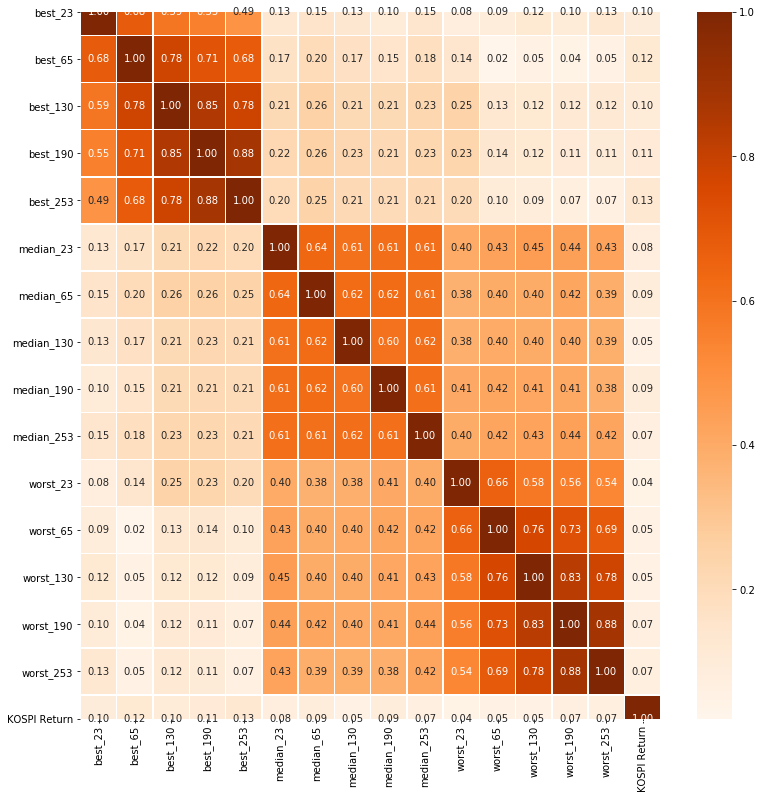

In [ ]:
plt.figure(figsize=(13,13))
sns.heatmap(data = ReturnLists.corr(), annot=True, 
fmt = '.2f', linewidths=.5, cmap='Oranges')

In [ ]:
plt.figure(figsize=(13,13))


<Figure size 936x936 with 0 Axes>

<Figure size 936x936 with 0 Axes>

In [ ]:
sns.pairplot(ReturnLists.corr())



```
6.  15개포트폴리오수익률과KOSPI지수 수익률의누적수익률그래프를그리시오.  (best  vs.  KOSPI,  median  vs.  KOSPI,  worst  vs.  KOSPI로구분하여3개의그래프로그릴것)
```



In [ ]:
CummulReturn = ReturnLists

tStartDay=datetime(2010,12,17).strftime("%Y-%m-%d")
End = datetime(2020,11,30).strftime("%Y-%m-%d")

In [ ]:
CummulReturn['best_23'] = np.cumsum(ReturnLists['best_23'])
CummulReturn['best_65'] = np.cumsum(ReturnLists['best_65'])
CummulReturn['best_130'] = np.cumsum(ReturnLists['best_130'])
CummulReturn['best_190'] = np.cumsum(ReturnLists['best_190'])
CummulReturn['best_253'] = np.cumsum(ReturnLists['best_253'])
CummulReturn['median_23'] = np.cumsum(ReturnLists['median_23'])
CummulReturn['median_65'] = np.cumsum(ReturnLists['median_65'])
CummulReturn['median_130'] = np.cumsum(ReturnLists['median_130'])
CummulReturn['median_190'] = np.cumsum(ReturnLists['median_190'])
CummulReturn['median_253'] = np.cumsum(ReturnLists['median_253'])
CummulReturn['worst_23'] = np.cumsum(ReturnLists['worst_23'])
CummulReturn['worst_65'] = np.cumsum(ReturnLists['worst_65'])
CummulReturn['worst_130'] = np.cumsum(ReturnLists['worst_130'])
CummulReturn['worst_190'] = np.cumsum(ReturnLists['worst_190'])
CummulReturn['worst_253'] = np.cumsum(ReturnLists['worst_253'])
CummulReturn['KOSPI Return'] = np.cumsum(ReturnLists['KOSPI Return'])

In [ ]:
CummulReturn

,best_23,best_65,best_130,best_190,best_253,median_23,median_65,median_130,median_190,median_253,worst_23,worst_65,worst_130,worst_190,worst_253,KOSPI Return
Date,,,,,,,,,,,,,,,,
2011-01-05,-2.742422,-4.218809,-3.753996,1.223779,0.265308,-0.205954,-0.025481,0.001052,-0.714788,0.065661,-2.158948,-0.642811,-0.234934,0.339566,-0.120361,-0.124282
2011-01-06,-3.364407,-1.904389,-0.845576,0.908840,1.301669,-0.480698,0.118072,0.002593,-0.693114,-0.152891,-1.989660,-0.494788,0.152284,0.987675,1.311762,-0.361770
2011-01-07,-1.612327,0.531797,2.373120,4.971560,5.116425,-0.084606,-0.650423,1.251870,-0.731734,-0.950870,-1.918695,1.495153,0.174219,1.443024,1.327241,0.050826
2011-01-10,-3.819056,-0.988120,-0.794759,2.868110,4.153106,0.370775,-1.000255,1.566889,-0.519431,-0.807780,-1.570875,1.612596,1.554877,0.800273,2.238147,-0.207868
2011-01-11,-2.637958,-1.715378,-1.122144,3.870895,5.256872,0.265081,-2.348643,3.647538,-0.111692,-1.169725,-1.273384,2.391927,2.364660,0.618511,2.082086,0.152400
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-11-24,-948.924080,-743.397630,-589.386467,-485.230376,-437.619776,42.497123,45.281946,18.835502,48.375576,53.491709,-22.511826,-172.939660,-107.558983,-80.337364,-178.116038,22.748305
2020-11-25,-949.583400,-743.995744,-589.604935,-485.047779,-437.659477,43.090219,45.271790,18.480333,48.870950,54.010653,-21.960007,-171.567416,-109.524667,-78.124359,-177.284312,22.126764
2020-11-26,-950.276551,-744.762092,-588.576924,-484.694702,-438.250353,43.515748,46.497929,18.321252,49.078855,54.149851,-20.625864,-170.716780,-108.642478,-78.755087,-179.042143,23.059152


C:\ProgramData\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


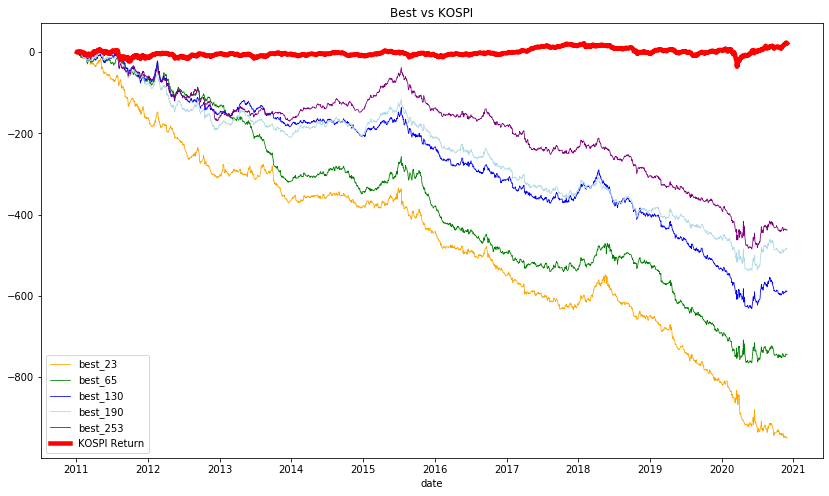

In [ ]:
plt.figure(figsize=(14, 8))

plt.plot(CummulReturn.index, CummulReturn['best_23'], c='orange', linewidth=0.8)
plt.plot(CummulReturn.index, CummulReturn['best_65'], c='g', linewidth=0.8)
plt.plot(CummulReturn.index, CummulReturn['best_130'], c='blue', linewidth=0.8)
plt.plot(CummulReturn.index, CummulReturn['best_190'], c='lightblue', linewidth=0.8)
plt.plot(CummulReturn.index, CummulReturn['best_253'], c='purple', linewidth=0.8)
plt.plot(CummulReturn.index, CummulReturn['KOSPI Return'], c='red', linewidth=4.5)

plt.xlabel('date')
plt.title('Best vs KOSPI')
plt.legend(['best_23', 'best_65', 'best_130', 'best_190', 'best_253', 'KOSPI Return'])

plt.show()

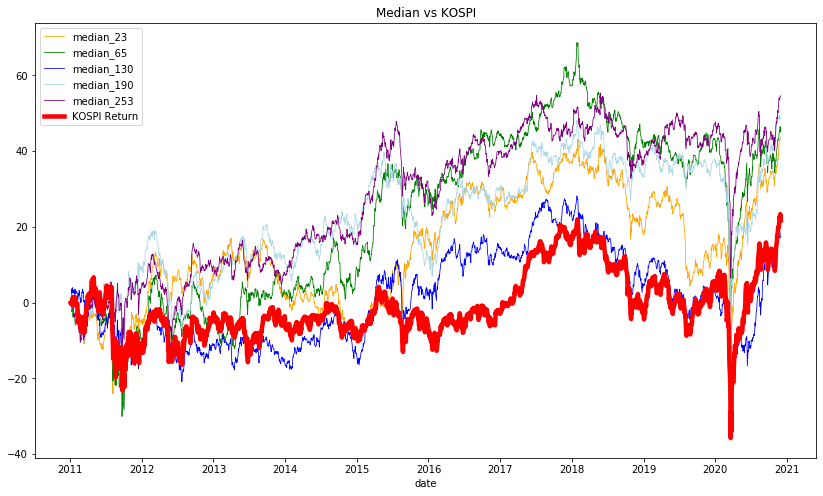

In [ ]:
plt.figure(figsize=(14, 8))

plt.plot(CummulReturn.index, CummulReturn['median_23'], c='orange', linewidth=0.8)
plt.plot(CummulReturn.index, CummulReturn['median_65'], c='g', linewidth=0.8)
plt.plot(CummulReturn.index, CummulReturn['median_130'], c='blue', linewidth=0.8)
plt.plot(CummulReturn.index, CummulReturn['median_190'], c='lightblue', linewidth=0.8)
plt.plot(CummulReturn.index, CummulReturn['median_253'], c='purple', linewidth=0.8)
plt.plot(CummulReturn.index, CummulReturn['KOSPI Return'], c='red', linewidth=4.5)

plt.xlabel('date')
plt.title('Median vs KOSPI')
plt.legend(['median_23', 'median_65', 'median_130', 'median_190', 'median_253', 'KOSPI Return'])

plt.show()

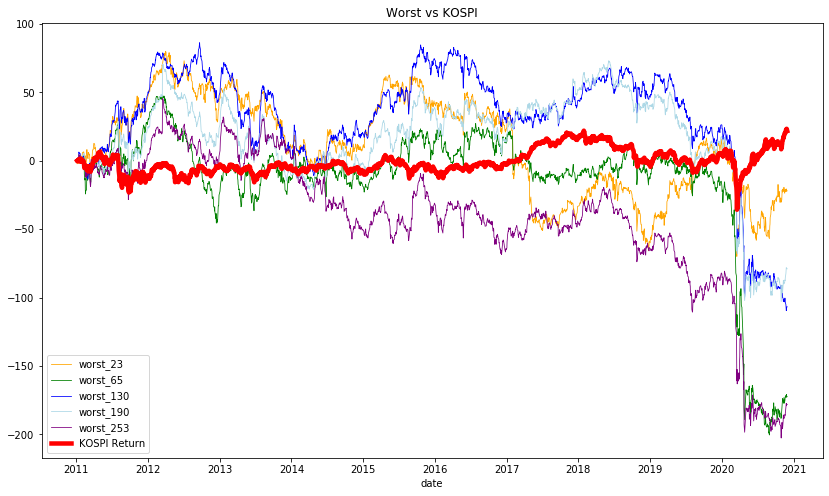

In [ ]:
plt.figure(figsize=(14, 8))

plt.plot(CummulReturn.index, CummulReturn['worst_23'], c='orange', linewidth=0.8)
plt.plot(CummulReturn.index, CummulReturn['worst_65'], c='g', linewidth=0.8)
plt.plot(CummulReturn.index, CummulReturn['worst_130'], c='blue', linewidth=0.8)
plt.plot(CummulReturn.index, CummulReturn['worst_190'], c='lightblue', linewidth=0.8)
plt.plot(CummulReturn.index, CummulReturn['worst_253'], c='purple', linewidth=0.8)
plt.plot(CummulReturn.index, CummulReturn['KOSPI Return'], c='red', linewidth=4.5)

plt.xlabel('date')
plt.title('Worst vs KOSPI')
plt.legend(['worst_23', 'worst_65', 'worst_130', 'worst_190', 'worst_253', 'KOSPI Return'])

plt.show()



```
7.위결과를바탕으로최적의투자전략을제시하고,그근거를설명하시오.
```





```
8.모멘텀기간의변화(23일∼253일)에따른portfolio(best, median, worst)의누적수익률을계산하고그래프로출력하시오. (x축:모멘텀기간의변화(23일∼253일);y축:모멘텀기간의변화에따른포트폴리오별최종시점의누적수익률추이)
```

